## Additional Preprocessing

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from catboost import CatBoostClassifier
from category_encoders import CountEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv("/content/Train_fe.csv")
df.head()

,Unnamed: 0,User_ID,month,year,CompPart,Comment,Sub,Disc,Target,is_train,...,Num_Comm_Per_Month_trend,Num_Comm_Prev_Month_momentum,Num_Comm_Prev_Month_momentum2,User_ID_nunique,Total_Num_User_Months_mean,Total_Num_User_Months_max,Total_Num_User_Months_std,Months_Since_Last_Activity_Mean,unique_user_count,user_interests_rank
0,0,ID_000VV0KM,12,2,1.0,0.0,1.0,0.0,CompPart,1,...,NaN,NaN,NaN,9470.0,7.598310,21.0,5.522981,NaN,978.0,1.0
1,1,ID_000VV0KM,1,3,0.0,0.0,0.0,0.0,NoActivity,1,...,0.0,NaN,NaN,10455.0,7.882449,22.0,5.705838,NaN,985.0,1.0
2,2,ID_000VV0KM,2,3,0.0,0.0,0.0,0.0,NoActivity,1,...,0.0,0.0,NaN,11623.0,8.090338,23.0,5.907749,7.778175,1168.0,1.0
3,3,ID_000VV0KM,3,3,0.0,0.0,0.0,0.0,NoActivity,1,...,0.0,0.0,0.0,12745.0,8.378109,24.0,6.089666,NaN,1122.0,1.0
4,4,ID_000VV0KM,4,3,0.0,0.0,0.0,0.0,NoActivity,1,...,0.0,0.0,0.0,13837.0,8.716918,25.0,6.265773,5.656854,1092.0,1.0


In [ ]:
label_encoder = LabelEncoder()
df['Target'] = label_encoder.fit_transform(df['Target'])
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = df[numerical_cols].corr()

target_corr = corr_matrix['Target'].sort_values(ascending=False)

print(target_corr.sort_values())

CompPart                     -0.931272
Sub                          -0.335851
Num_Comp_Per_Month           -0.162886
Disc                         -0.148528
Comment                      -0.119532
                                ...   
Total_Num_User_Months_mean    0.109650
Total_Num_User_Months         0.122064
Target                        1.000000
is_train                           NaN
Record                             NaN
Name: Target, Length: 71, dtype: float64


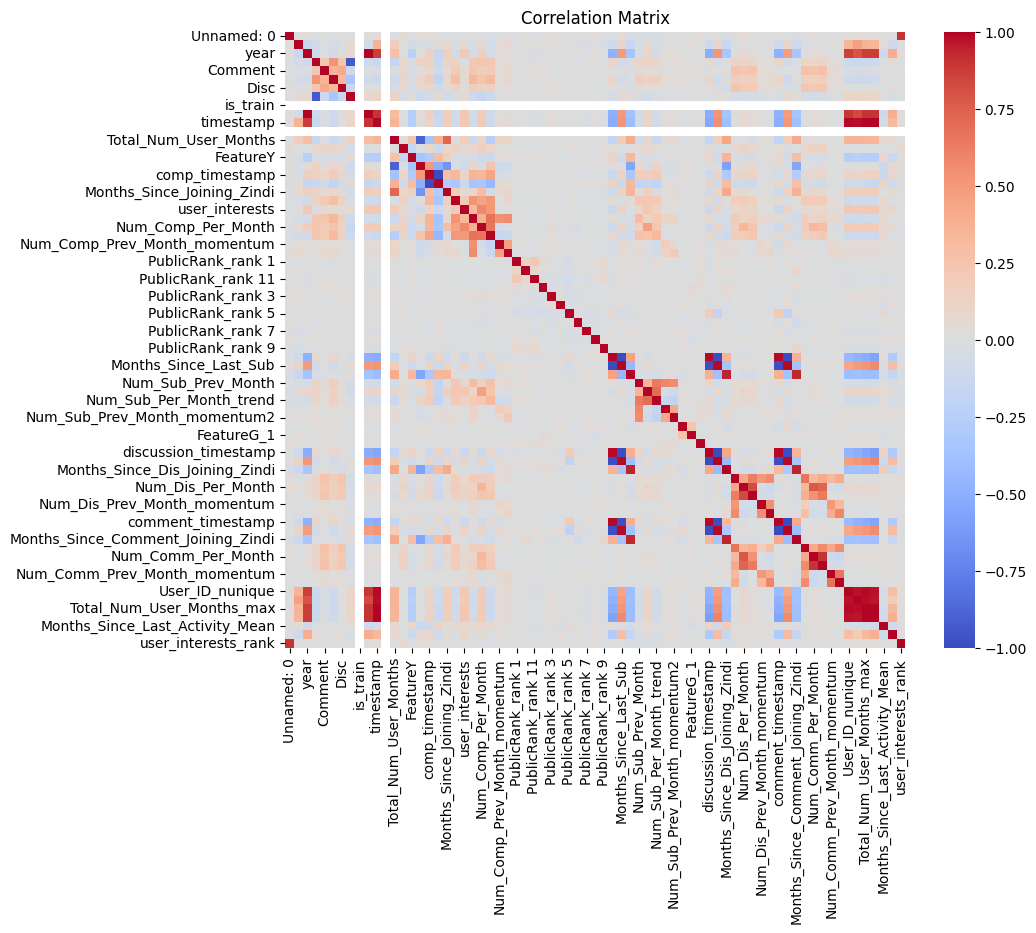

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

As can be seen, there are one feature that strongly correlates with our target variable -- **CompPart**.  
In order to improve a model's ability to generalize to new data, reduce the risk of overfitting and make the model more robust, we remove this feature from the train set along with target variable.

# Baseline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Define the list of features to add sequentially
features = ['CompPart', 'Sub', 'Comment', 'Disc']
y = df['Target']
results = []

# Iterate over the number of features to include in the model
for i in range(1, len(features) + 1):
    # Select the subset of features
    X = df[features[:i]]

    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Scaling features
    scaler = StandardScaler()
    # Use reshape for single feature case to avoid shape issues in scaling
    if i == 1:
        X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))
        X_test_scaled = scaler.transform(X_test.values.reshape(-1, 1))
    else:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

    # Creating and fitting the logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Predicting the test set results
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)  # probabilities for AUC

    # Evaluating the model
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    results.append({
        'Features': ', '.join(features[:i]),
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1:.3f}",
        'AUC Score': f"{auc:.3f}"
    })

# Print the results for each feature set
for result in results:
    print(f"Using features: {result['Features']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1 Score: {result['F1 Score']}")
    print(f"AUC Score: {result['AUC Score']}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Using features: CompPart
Precision: 0.966
Recall: 0.983
F1 Score: 0.974
AUC Score: 0.833

Using features: CompPart, Sub
Precision: 0.998
Recall: 0.998
F1 Score: 0.997
AUC Score: 0.976

Using features: CompPart, Sub, Comment
Precision: 0.999
Recall: 0.999
F1 Score: 0.999
AUC Score: 0.986

Using features: CompPart, Sub, Comment, Disc
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
AUC Score: 1.000



The baseline model using logistic regression demonstrates a notable enhancement in predictive accuracy with the sequential addition of highly correlated features, arranged in descending order of their correlation strength. Starting with the 'CompPart' feature, the model already performs well with an F1 score of 0.974 and an AUC of 0.833. As more features like 'Sub' (Submissions), 'Comment', and 'Disc' (Discussions) are incorporated, each being highly correlated to user activity, the precision, recall, F1 score, and AUC scores increase incrementally. This strategic addition of correlated features, each building on the previous, culminates in perfect scores across all metrics, highlighting that these features together provide substantial leverage in enhancing the model’s ability to distinguish between active and inactive users with remarkable accuracy.

# Advanced Approach

In [ ]:
X = df.drop(['Target', 'CompPart'], axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print(f"Train: {y_train.value_counts()}\n\nTest: {y_test.value_counts()}")

Train: Target
1    12453
0     1738
2      248
Name: count, dtype: int64

Test: Target
1    3114
0     434
2      62
Name: count, dtype: int64


In [ ]:
cat_cols = list(set(X_train.columns[X_train.dtypes == 'object']) - set(['User_ID']) - set (['Country']))

X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [ ]:
X_train_encoded.drop(['User_ID', 'Country', 'Unnamed: 0'], axis=1, inplace=True)
X_test_encoded.drop(['User_ID', 'Country', 'Unnamed: 0'], axis=1, inplace=True)

## Classifiers

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

def grid_search_models(X_train, y_train):
    # Define the models and their hyperparameter grids
    models = {
        'LogisticRegression': (LogisticRegression(multi_class='ovr', penalty='l2', max_iter=1000), {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }),
        'LassoRegression': (LogisticRegression(multi_class='ovr', penalty='l1', max_iter=1000), {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear']
        }),
        'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [200],
            'max_depth': [5, 7],
            'subsample': [0.5, 0.75, 1.0]
        }),
        'LightGBM': (lgb.LGBMClassifier(), {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [200],
            'max_depth': [5, 7],
            'num_leaves': [31, 50, 70]
        }),
    }

    results = {}

    for model_name, (model, params) in models.items():
      grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='f1', n_jobs=-1, verbose=3)
      if model_name == ('LogisticRegression') or (model_name =='LassoRegression'):
        X_train_dropped = X_train.dropna()
        y_train_dropped = y_train.loc[X_train_dropped.index]
        grid_search.fit(X_train_dropped, y_train_dropped)

      else:
        grid_search.fit(X_train, y_train)

        results[model_name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
        }

    return results

In [ ]:
results = grid_search_models(X_train_encoded, y_train)
print(results)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5475
[LightGBM] [Info] Number of data points in the train set: 14439, number of used features: 69
[LightGBM] [Info] Start training from score -2.117198
[LightGBM] [Info] Start training from score -0.147971
[LightGBM] [Info] Start training from score -4.064259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [ ]:
from sklearn.impute import SimpleImputer
def train_with_folds(X_train, X_test, y_train, y_test, model_name='LGB'):
    # Handle missing data
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    f1_test = auc_test = None

    if model_name == 'LGB':
        model = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_class=len(np.unique(y_train)), random_state=42)
        f1_test, auc_test = train_and_predict(X_train, X_test, y_train, y_test, model)

    elif model_name == 'XGB':
        params = {'n_estimators': 200, 'random_state': 123, 'learning_rate': 0.01, 'colsample_bytree': 0.3, 'max_depth': 6}
        model = xgb.XGBClassifier(**params, objective='multi:softmax', num_class=len(np.unique(y_train)))
        f1_test, auc_test = train_and_predict(X_train, X_test, y_train, y_test, model)

    elif model_name == 'log_reg':
        model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        auc_test = roc_auc_score(y_test, y_test_prob, multi_class='ovr', average='weighted')

    elif model_name == 'lasso_log_reg':
        model = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga', max_iter=1000)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        auc_test = roc_auc_score(y_test, y_test_prob, multi_class='ovr', average='weighted')

    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    return f1_test, auc_test

In [ ]:
def train_and_predict(X_train, X_test, y_train, y_test, model, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_f1_scores = []
    fold_auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"Training fold {fold + 1}/{n_splits}...")

        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        y_val_prob = model.predict_proba(X_val_fold)

        val_f1 = f1_score(y_val_fold, y_val_pred, average='weighted')
        fold_f1_scores.append(val_f1)

        val_auc = roc_auc_score(y_val_fold, y_val_prob, multi_class='ovr', average='weighted')
        fold_auc_scores.append(val_auc)

        print(f"Fold {fold + 1} F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    mean_f1 = np.mean(fold_f1_scores)
    mean_auc = np.mean(fold_auc_scores)

    print(f"\nMean F1 across all folds: {mean_f1:.4f}")
    print(f"Mean AUC across all folds: {mean_auc:.4f}")

    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr', average='weighted')

    print(f"\nTest Set F1: {test_f1:.4f}")
    print(f"Test Set AUC: {test_auc:.4f}")

    return test_f1, test_auc

In [ ]:
xgb_acc, xgb_auc = train_with_folds(X_train_encoded, X_test_encoded, y_train, y_test, model_name='XGB')

Training fold 1/5...
Fold 1 F1: 0.9044, AUC: 0.9268
Training fold 2/5...
Fold 2 F1: 0.8927, AUC: 0.9292
Training fold 3/5...
Fold 3 F1: 0.8939, AUC: 0.9416
Training fold 4/5...
Fold 4 F1: 0.8986, AUC: 0.9208
Training fold 5/5...
Fold 5 F1: 0.8915, AUC: 0.9225

Mean F1 across all folds: 0.8962
Mean AUC across all folds: 0.9282

Test Set F1: 0.9017
Test Set AUC: 0.9224


In [ ]:
logreg_acc, logreg_auc = train_with_folds(X_train_encoded, X_test_encoded, y_train, y_test, model_name='log_reg')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(f"\nTest Set F1: {logreg_acc:.4f}")
print(f"Test Set AUC: {logreg_auc:.4f}")


Test Set F1: 0.8136
Test Set AUC: 0.8337


In [ ]:
lasso_acc, lasso_auc = train_with_folds(X_train_encoded, X_test_encoded, y_train, y_test, model_name='lasso_log_reg')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(f"\nTest Set F1: {lasso_acc:.4f}")
print(f"Test Set AUC: {lasso_auc:.4f}")


Test Set F1: 0.7990
Test Set AUC: 0.6973


In [ ]:
lgb_acc, lgb_auc = train_with_folds(X_train_encoded, X_test_encoded, y_train, y_test, model_name='LGB')

Training fold 1/5...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4846
[LightGBM] [Info] Number of data points in the train set: 11551, number of used features: 69
[LightGBM] [Info] Start training from score -2.117468
[LightGBM] [Info] Start training from score -0.147994
[LightGBM] [Info] Start training from score -4.061222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1 F1: 0.9213, AUC: 0.9248
Training fold 2/5...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [ ]:
models = ['LGBmClassifier', 'XGBoostClassifier', 'Logistic Regression', 'L1 Logistic Regression']

plot_foundation = {}
for i in models:
  plot_foundation[i] = {'f1': 0, 'auc': 0}

In [ ]:
plot_foundation['LGBmClassifier']['f1'] = lgb_acc
plot_foundation['LGBmClassifier']['auc'] = lgb_auc

plot_foundation['XGBoostClassifier']['f1'] = xgb_acc
plot_foundation['XGBoostClassifier']['auc'] = xgb_auc

plot_foundation['Logistic Regression']['f1'] = logreg_acc
plot_foundation['Logistic Regression']['auc'] = logreg_auc

plot_foundation['L1 Logistic Regression']['f1'] = lasso_acc
plot_foundation['L1 Logistic Regression']['auc'] = lasso_auc

In [ ]:
plot_foundation

{'LGBmClassifier': {'f1': 0.9131115540059822, 'auc': 0.9150528282449666},
 'XGBoostClassifier': {'f1': 0.9017009410185487, 'auc': 0.922381008099639},
 'Logistic Regression': {'f1': 0.8135855987491495, 'auc': 0.833667540429017},
 'L1 Logistic Regression': {'f1': 0.7989733719376245,
  'auc': 0.6972986197249262}}

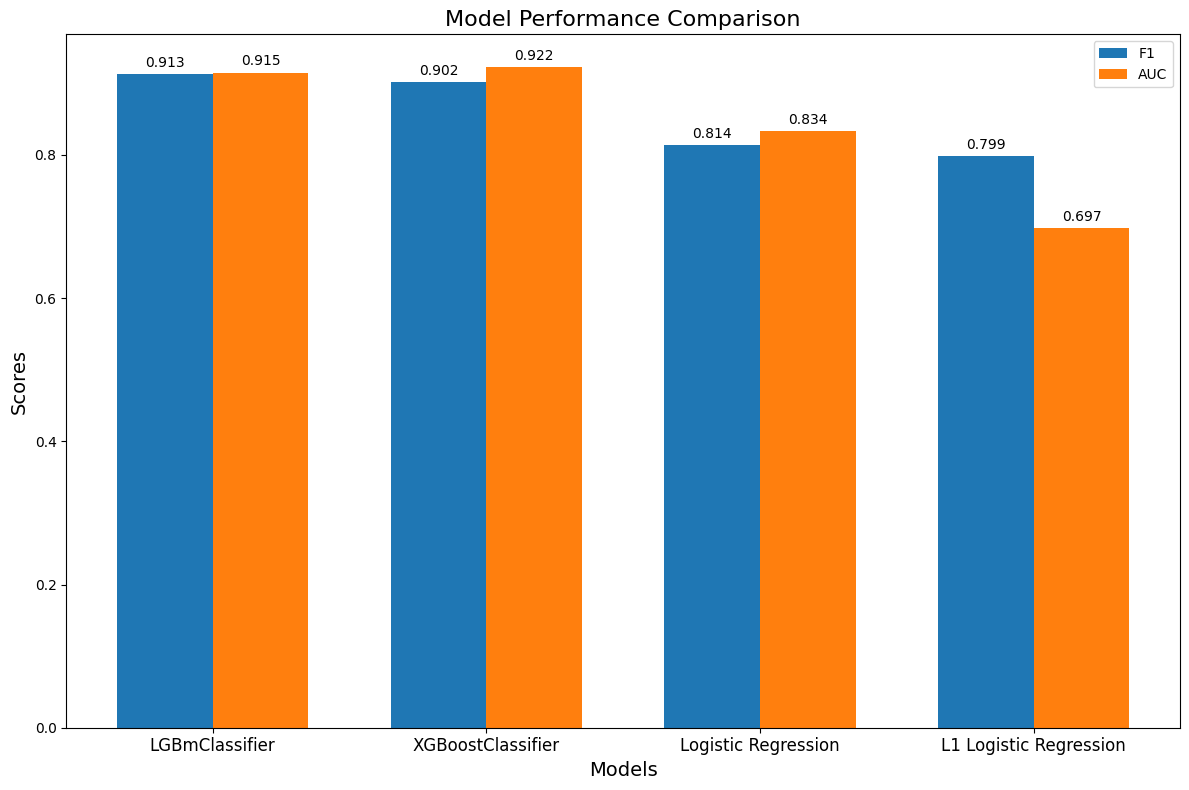

In [ ]:
models = list(plot_foundation.keys())
f1 = [plot_foundation[model]['f1'] for model in models]
auc = [plot_foundation[model]['auc'] for model in models]

# Set up bar width and x locations
bar_width = 0.35
x = np.arange(len(models))

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - bar_width/2, f1, bar_width, label='F1')
bars2 = ax.bar(x + bar_width/2, auc, bar_width, label='AUC')

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Adding value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()